In [24]:
# Install necessary libraries
# !pip install pyspark findspark

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [26]:
# Spark Setup
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, udf
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType

In [27]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# File Paths in Google Drive
gspc_file_path = '/content/drive/MyDrive/gspc_daily_price.csv'
vix_file_path = '/content/drive/MyDrive/vix_daily_price.csv'
sentiment_file_path = '/content/drive/MyDrive/news_sentiment_data.csv'

In [29]:
# Load Data using Pandas
try:
    gspc_df = pd.read_csv(gspc_file_path, parse_dates=['Date'], encoding='latin1')
    print("S&P 500 Data loaded successfully with latin1 encoding.")
except UnicodeDecodeError:
    try:
        gspc_df = pd.read_csv(gspc_file_path, parse_dates=['Date'], encoding='cp1252')
        print("S&P 500 Data loaded successfully with cp1252 encoding.")
    except UnicodeDecodeError as e:
        print(f"Error loading S&P 500 Data: {e}")

vix_df = pd.read_csv(vix_file_path, parse_dates=['Date'])
sentiment_df = pd.read_csv(sentiment_file_path, parse_dates=['date'])

S&P 500 Data loaded successfully with latin1 encoding.


<ipython-input-29-1d3660539135>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gspc_df = pd.read_csv(gspc_file_path, parse_dates=['Date'], encoding='latin1')
<ipython-input-29-1d3660539135>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  vix_df = pd.read_csv(vix_file_path, parse_dates=['Date'])


In [30]:
# Display First Few Rows
print("\nS&P 500 Data:")
print(gspc_df.head())
print("\nVIX Data:")
print(vix_df.head())
print("\nSentiment Data:")
print(sentiment_df.head())


S&P 500 Data:
        Date     Open     High      Low   Close       Volume
0 2025-03-17  5635.60  5703.52  5631.12  5675.12  5031770000
1 2025-03-14  5563.85  5645.27  5563.85  5638.94  4863180000
2 2025-03-13  5594.45  5597.78  5504.65  5521.52  5018980000
3 2025-03-12  5624.84  5642.19  5546.09  5599.30  5219830000
4 2025-03-11  5603.65  5636.30  5528.41  5572.07  6221240000

VIX Data:
        Date   Open   High    Low  Close 
0 2025-03-17  22.89  22.95  20.32   20.51
1 2025-03-14  24.35  24.36  21.48   21.77
2 2025-03-13  24.92  26.13  23.46   24.66
3 2025-03-12  26.88  26.91  23.89   24.23
4 2025-03-11  27.94  29.57  26.18   26.92

Sentiment Data:
        date  News Sentiment
0 2025-03-17           -0.12
1 2025-03-16           -0.12
2 2025-03-15           -0.10
3 2025-03-14           -0.09
4 2025-03-13           -0.08


In [31]:
# Data Preprocessing
print("\nPreprocessing Data...")
gspc_df.rename(columns={'Close ': 'Close', 'Open ': 'Open', 'High ': 'High', 'Low ': 'Low', 'Volume ': 'Volume'}, inplace=True)
vix_df.rename(columns={'Close ': 'Close', 'Open ': 'Open', 'High ': 'High', 'Low ': 'Low'}, inplace=True)
sentiment_df.rename(columns={'date': 'Date'}, inplace=True)


Preprocessing Data...


In [32]:
# Ensure Data Consistency
gspc_df.sort_values(by='Date', inplace=True)
vix_df.sort_values(by='Date', inplace=True)
sentiment_df.sort_values(by='Date', inplace=True)

In [33]:
# Merge Data
print("Merging Data...")
df = pd.merge(gspc_df, vix_df, on='Date', suffixes=('_sp500', '_vix'))
df = pd.merge(df, sentiment_df, on='Date', how='left')
df.fillna(0, inplace=True)

print(df.columns)
df.columns = df.columns.str.replace('\xa0', '')
print(df.columns)
print(df.dtypes)

Merging Data...
Index(['Date', 'Open_sp500', 'High_sp500', 'Low_sp500', 'Close _sp500',
       'Volume', 'Open_vix', 'High_vix', 'Low_vix', 'Close _vix',
       'News Sentiment'],
      dtype='object')
Index(['Date', 'Open_sp500', 'High_sp500', 'Low_sp500', 'Close_sp500',
       'Volume', 'Open_vix', 'High_vix', 'Low_vix', 'Close_vix',
       'News Sentiment'],
      dtype='object')
Date              datetime64[ns]
Open_sp500               float64
High_sp500               float64
Low_sp500                float64
Close_sp500              float64
Volume                     int64
Open_vix                 float64
High_vix                 float64
Low_vix                  float64
Close_vix                float64
News Sentiment           float64
dtype: object


In [34]:
# Calculate RSI (14-Day)
def calculate_rsi(data, window=14):
    delta = data['Close_sp500'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df)
print(df.tail())

          Date  Open_sp500  High_sp500  Low_sp500  Close_sp500      Volume  \
245 2025-03-11     5603.65     5636.30    5528.41      5572.07  6221240000   
246 2025-03-12     5624.84     5642.19    5546.09      5599.30  5219830000   
247 2025-03-13     5594.45     5597.78    5504.65      5521.52  5018980000   
248 2025-03-14     5563.85     5645.27    5563.85      5638.94  4863180000   
249 2025-03-17     5635.60     5703.52    5631.12      5675.12  5031770000   

     Open_vix  High_vix  Low_vix  Close_vix  News Sentiment     RSI_14  
245     27.94     29.57    26.18      26.92           -0.05  19.949994  
246     26.88     26.91    23.89      24.23           -0.07  22.796279  
247     24.92     26.13    23.46      24.66           -0.08  23.451456  
248     24.35     24.36    21.48      21.77           -0.09  33.012305  
249     22.89     22.95    20.32      20.51           -0.12  36.289509  


In [35]:
# Select Last 30 Days
df_last_30 = df.tail(30)

Visualizing Data...


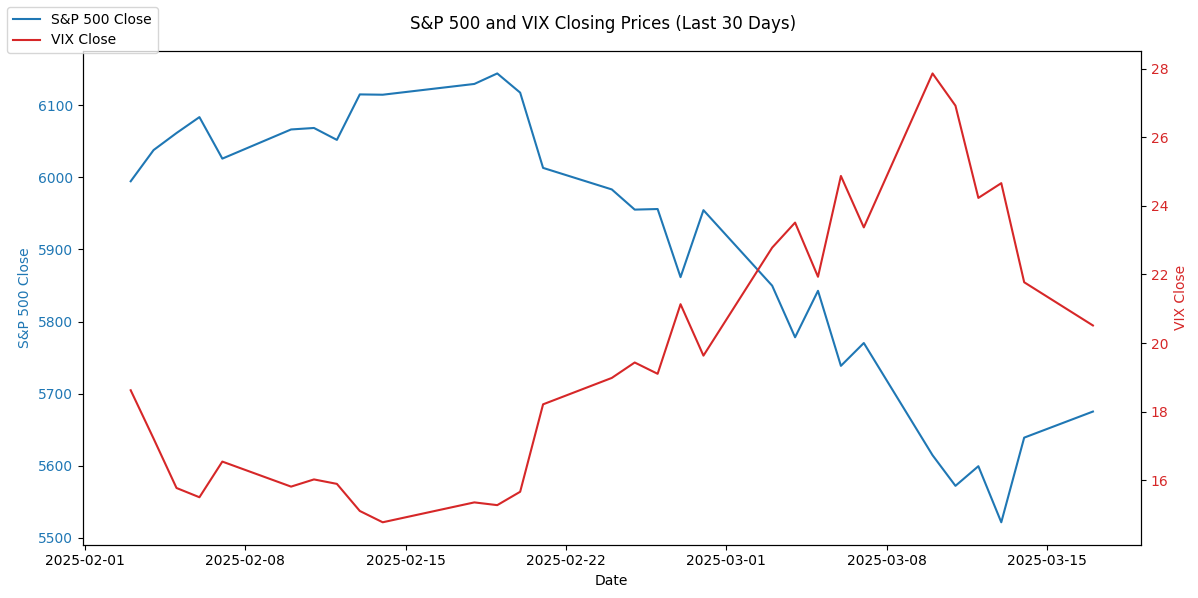

In [36]:
# Visualization with Secondary Y-Axis
print("Visualizing Data...")
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 Close', color=color)
ax1.plot(df_last_30['Date'], df_last_30['Close_sp500'], color=color, label='S&P 500 Close')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('VIX Close', color=color)
ax2.plot(df_last_30['Date'], df_last_30['Close_vix'], color=color, label='VIX Close')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('S&P 500 and VIX Closing Prices (Last 30 Days)')
fig.tight_layout()

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
fig.legend(lines, labels, loc='upper left')

plt.show()

Visualizing S&P 500 vs. News Sentiment...


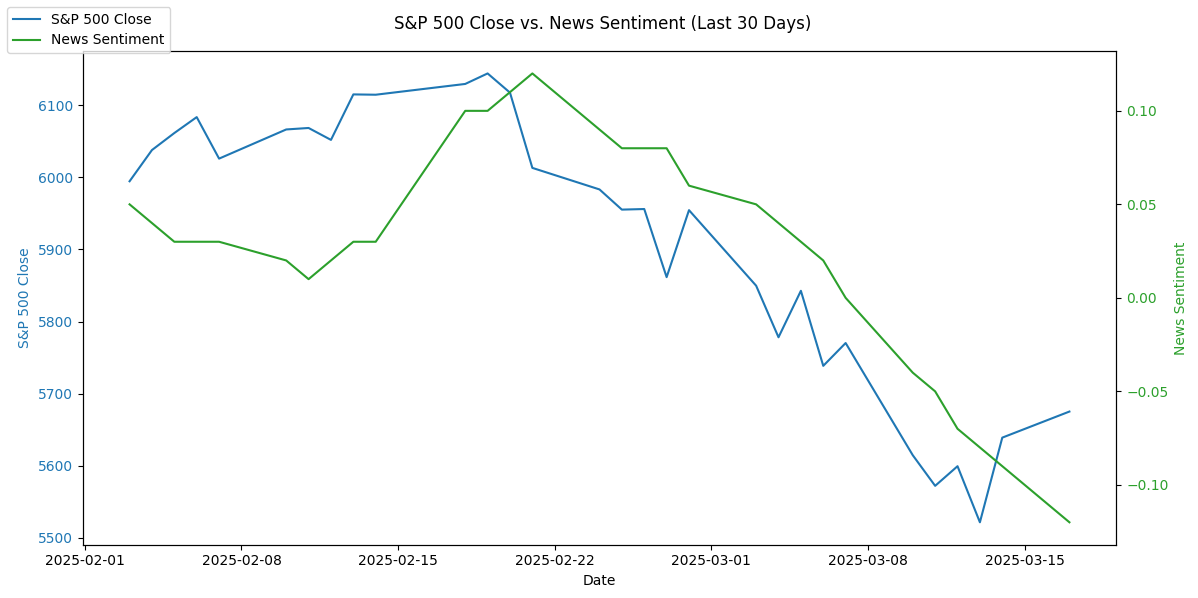

In [37]:
# Visualization: S&P 500 Close vs. News Sentiment
print("Visualizing S&P 500 vs. News Sentiment...")
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 Close', color=color)
ax1.plot(df_last_30['Date'], df_last_30['Close_sp500'], color=color, label='S&P 500 Close')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('News Sentiment', color=color)
ax2.plot(df_last_30['Date'], df_last_30['News Sentiment'], color=color, label='News Sentiment')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('S&P 500 Close vs. News Sentiment (Last 30 Days)')
fig.tight_layout()

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
fig.legend(lines, labels, loc='upper left')

plt.show()

Visualizing S&P 500 vs. RSI...


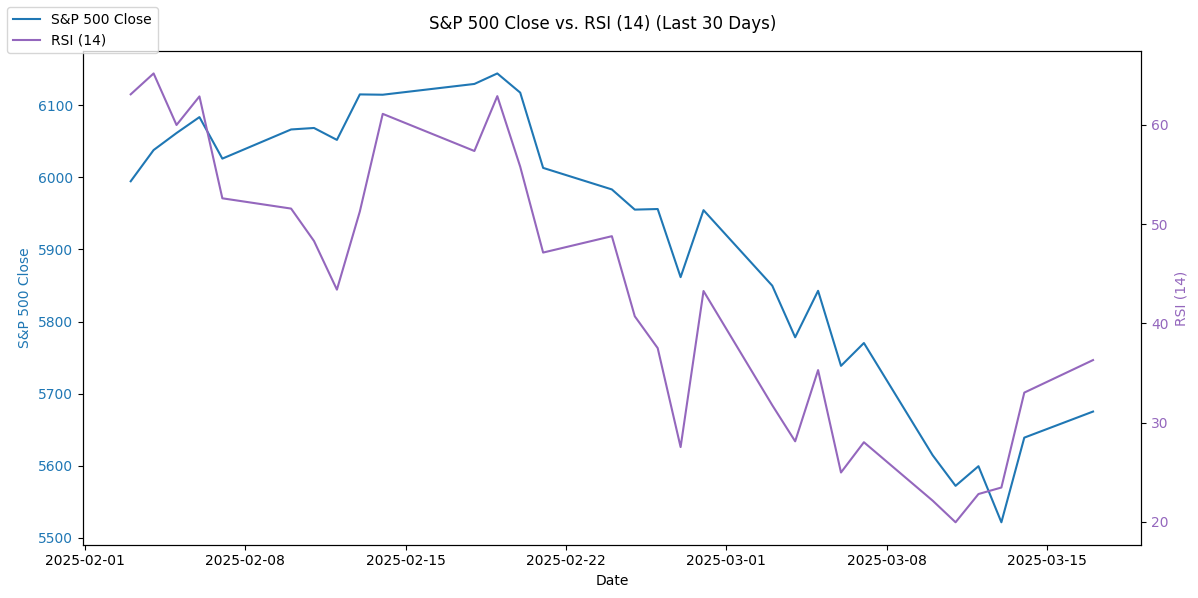

In [38]:
# Visualization: S&P 500 Close vs. RSI
print("Visualizing S&P 500 vs. RSI...")
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 Close', color=color)
ax1.plot(df_last_30['Date'], df_last_30['Close_sp500'], color=color, label='S&P 500 Close')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('RSI (14)', color=color)
ax2.plot(df_last_30['Date'], df_last_30['RSI_14'], color=color, label='RSI (14)')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('S&P 500 Close vs. RSI (14) (Last 30 Days)')
fig.tight_layout()

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
fig.legend(lines, labels, loc='upper left')

plt.show()

In [39]:
# Prepare Features and Target
df['Next_Day_Close'] = df['Close_sp500'].shift(-1)

In [40]:
# Drop NaN values after shifting
df_cleaned = df.dropna()

In [41]:
# Use the last 30 days for model training and testing
df_last_30_cleaned = df_cleaned.tail(30)

features = ['Open_sp500', 'High_sp500', 'Low_sp500', 'Close_sp500', 'Volume', 'RSI_14', 'Close_vix', 'News Sentiment']
X = df_last_30_cleaned[features]
y = df_last_30_cleaned['Next_Day_Close']

In [42]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Model Training
print("Training Linear Regression Model...")
model = LinearRegression()
model.fit(X_train, y_train)

Training Linear Regression Model...


LinearRegression()

In [44]:
# Predictions and Evaluation
y_pred = model.predict(X_test)

In [45]:
dfr = pd.DataFrame({'Actual_Price': y_test, 'predicted_price': y_pred})
print(dfr.head(10))

     Actual_Price  predicted_price
246       5521.52      5605.390713
234       5955.25      6049.903090
242       5770.20      5813.132421
236       5861.57      6010.290696
227       6115.07      6000.461865
228       6114.63      6038.789168


In [46]:
print("\nModel Evaluation:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"R^2 Score: {r2_score(y_test, y_pred)}")


Model Evaluation:
Mean Absolute Error: 93.43764778636235
Mean Squared Error: 9806.899748130349
R^2 Score: 0.7704287865337099


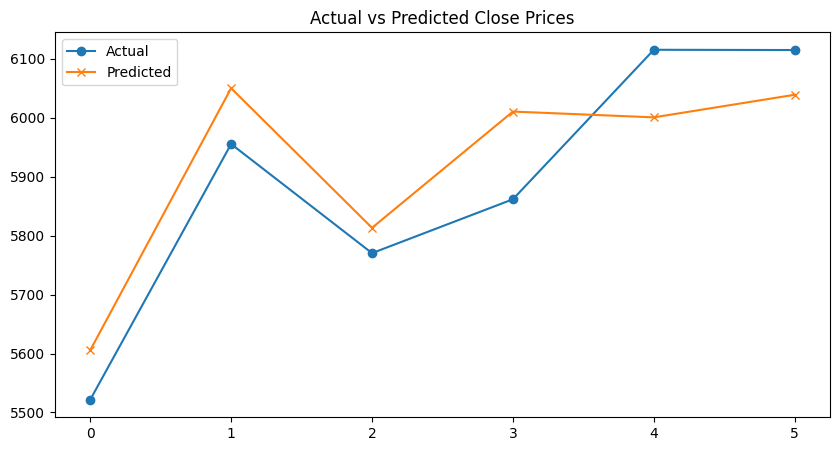

In [47]:
# Visualizing Predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.show()


In [48]:
# Predict Tomorrow's Price
print("\nPredicting Tomorrow's Price...")

# Get the latest data
latest_data = df_cleaned.tail(1)  # Use df_cleaned

# Prepare the input for prediction
tomorrow_input = latest_data[features]

# Make the prediction
tomorrow_prediction = model.predict(tomorrow_input)[0]


Predicting Tomorrow's Price...


In [49]:
# Get today's closing price
today_close = df_cleaned['Close_sp500'].iloc[-1]

# Calculate the change and percentage change
price_change = tomorrow_prediction - today_close
percentage_change = (price_change / today_close) * 100

# Print the predicted price and change
print(f"Predicted S&P 500 Close for Tomorrow: {tomorrow_prediction:.2f}")
print(f"Predicted Change: {price_change:.2f} points ({percentage_change:.2f}%)")

Predicted S&P 500 Close for Tomorrow: 5690.13
Predicted Change: 51.19 points (0.91%)
